In [1]:
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
from mozaik.storage.datastore import PickledDataStore
from parameters import ParameterSet
from mozaik.storage.queries import *
import sys
%matplotlib inline
from mozaik.tools.distribution_parametrization import load_parameters, MozaikExtendedParameterSet
import logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
import numpy as np
import scipy

In [2]:
# Load datastore containing results
path = "LSV1M_test_____/"

data_store = PickledDataStore(
    load=True,
    parameters=ParameterSet({"root_directory": path, "store_stimuli": False}),
    replace=False,
)

In [3]:
# Show what's in the data store
data_store.print_content()

INFO:Mozaik:DSV info:
INFO:Mozaik:   Number of recordings: 24
INFO:Mozaik:     InternalStimulus : 12
INFO:Mozaik:     EndOfSimulationBlank : 12
INFO:Mozaik:   Number of ADS: 0


In [4]:
# Filter out datastore results to just Layer 2/3 and our stimulus of interest
# (EndOfSimulationBlank is the blank between stimuli to reset activity)
filtered_data_store = param_filter_query(data_store,sheet_name="V1_Exc_L2/3",st_name="InternalStimulus")

In [5]:
# Show what's in the filtered data store
filtered_data_store.print_content()

INFO:Mozaik:DSV info:
INFO:Mozaik:   Number of recordings: 2
INFO:Mozaik:     InternalStimulus : 2
INFO:Mozaik:   Number of ADS: 0


In [6]:
# Print number of stored segments in filtered data store
print(len(filtered_data_store.get_segments()))

1


In [7]:
from mozaik.analysis.technical import NeuronAnnotationsToPerNeuronValues

def orientation_preferences(filtered_data_store, neuron_ids, sheet):
    analysis_result = filtered_data_store.full_datastore.get_analysis_result(
        sheet_name=sheet,
        identifier="PerNeuronValue",
        value_name="LGNAfferentOrientation",
    )
    if len(analysis_result) == 0:
        NeuronAnnotationsToPerNeuronValues(filtered_data_store, ParameterSet({})).analyse()

    result = filtered_data_store.full_datastore.get_analysis_result(
        sheet_name=sheet,
        identifier="PerNeuronValue",
        value_name="LGNAfferentOrientation",
    )[0]
    return np.array(result.get_value_by_id(neuron_ids))

# Category
# Select excitatory neurons in Layer 2/3
filtered_data_store = param_filter_query(data_store,sheet_name="V1_Exc_L2/3",st_name="InternalStimulus")
# Select inhibitory neurons in Layer 2/3
filtered_data_store = param_filter_query(data_store,sheet_name="V1_Inh_L2/3",st_name="InternalStimulus")
# Select excitatory neurons in Layer 4
filtered_data_store = param_filter_query(data_store,sheet_name="V1_Exc_L4",st_name="InternalStimulus")
# Select inhibitory neurons in Layer 4
filtered_data_store = param_filter_query(data_store,sheet_name="V1_Inh_L4",st_name="InternalStimulus")

filtered_data_store = param_filter_query(data_store,sheet_name="V1_Exc_L2/3",st_name="InternalStimulus")
neuron_ids = [s for s in filtered_data_store.get_segments() if len(s.spiketrains) > 0][0].get_stored_esyn_ids()

In [8]:
# Load IDs of neurons from which we recorded spikes
st_ids = [s for s in filtered_data_store.get_segments() if len(s.spiketrains) > 0][
    0
].get_stored_spike_train_ids()

# Load spike trains for these neurons
spiketrains = filtered_data_store.get_segments()[0].get_spiketrains()
spikecounts = np.array([len(st) for st in spiketrains])

# Load cortical positions for these neurons
pos = data_store.get_neuron_positions()["V1_Exc_L2/3"]
posx = pos[0, data_store.get_sheet_indexes("V1_Exc_L2/3", st_ids)]
posy = pos[1, data_store.get_sheet_indexes("V1_Exc_L2/3", st_ids)]

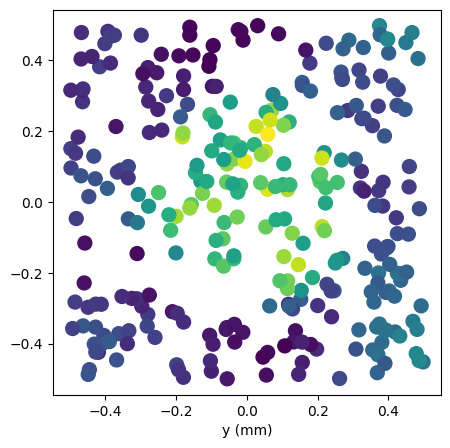

In [9]:
plt.figure(figsize=(5,5))
im = plt.scatter(posx, posy, c=spikecounts, cmap='viridis', s=100)
plt.axis('equal')
plt.xlabel("x (mm)")
plt.xlabel("y (mm)")
plt.show()

In [13]:
# Calculate mean firing rate inside circle of 300um radius
inside_circle = np.sqrt(posx**2 + posy**2) < 300
bin_size = 10 # ms

# Hacky way of loading experiment parameters from Mozaik
experiment_parameters = load_parameters(filtered_data_store.get_stimuli()[0].replace("MozaikExtended",""))

firing_rate = np.zeros((experiment_parameters["duration"] // bin_size+1))
for i, st in enumerate(spiketrains):
    if inside_circle[i]:
        indices, counts = np.unique((np.array(st) / bin_size).astype(int),return_counts=True)
        firing_rate[indices] += counts

firing_rate /= (bin_size /1000) * np.sum(inside_circle)

[        nan         nan         nan ... 15.00355295 15.00157912
 15.00039478]


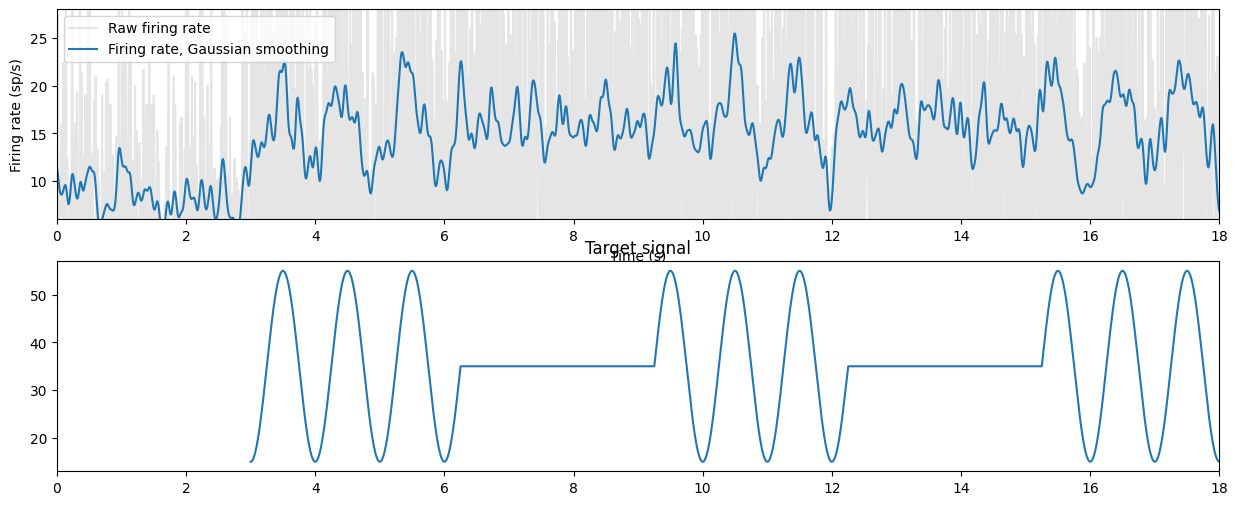

In [22]:
exp_kernel = 0.1 * 0.9**np.arange(40)

fig,ax = plt.subplots(2,1,figsize=(15,6))
ax[0].plot(np.arange(len(firing_rate))*bin_size / 1000,firing_rate,alpha=0.1,color='k')
ax[0].plot(np.arange(len(firing_rate))*bin_size / 1000,scipy.ndimage.gaussian_filter1d(firing_rate,3))
ax[0].set_ylim(6,28)
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("Firing rate (sp/s)")
ax[0].set_xlim(0,18)
ax[0].legend(["Raw firing rate","Firing rate, Gaussian smoothing"])


t = np.arange(experiment_parameters["duration"]) / 1000.0
target_signal = 35 + 20 * np.sin(2 * np.pi * 1 * t - np.pi/2)
# 修改：在 5.5-10.5 s 和 15.5-20.5 s 之间保持恒定为 14
target_signal[(t >= 6.25) & (t < 9.25)] = 35
target_signal[(t >= 12.25) & (t < 15.25)] = 35
target_signal[t < 3] = np.nan
print(target_signal)
ax[1].plot(t,target_signal)
ax[1].set_title("Target signal")
ax[1].set_xlim(0,18)
plt.show()